# Combined Fit
Combined (simultaneous) fit of two histogram with separate functions
and some common parameters

See http://root.cern.ch/phpBB3//viewtopic.php?f=3&t=11740#p50908
for a modified version working with Fumili or GSLMultiFit

N.B. this macro must be compiled with ACliC




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 01:26 AM.</small></i>

In [1]:
%%cpp -d
#include "Fit/Fitter.h"
#include "Fit/BinData.h"
#include "Fit/Chi2FCN.h"
#include "TH1.h"
#include "TList.h"
#include "Math/WrappedMultiTF1.h"
#include "HFitInterface.h"
#include "TCanvas.h"
#include "TStyle.h"

Definition of shared parameter
 background function

In [2]:
int iparB[2] = { 0,      // exp amplitude in B histo
                 2    // exp common parameter
};

Signal + background function

In [3]:
int iparSB[5] = { 1, // exp amplitude in S+B histo
                  2, // exp common parameter
                  3, // gaussian amplitude
                  4, // gaussian mean
                  5  // gaussian sigma
};

Create the globalchi2 structure

In [4]:
struct GlobalChi2 {
   GlobalChi2(  ROOT::Math::IMultiGenFunction & f1,
                ROOT::Math::IMultiGenFunction & f2) :
      fChi2_1(&f1), fChi2_2(&f2) {}

   // parameter vector is first background (in common 1 and 2)
   // and then is signal (only in 2)
   double operator() (const double *par) const {
      double p1[2];
      for (int i = 0; i < 2; ++i) p1[i] = par[iparB[i] ];

      double p2[5];
      for (int i = 0; i < 5; ++i) p2[i] = par[iparSB[i] ];

      return (*fChi2_1)(p1) + (*fChi2_2)(p2);
   }

   const  ROOT::Math::IMultiGenFunction * fChi2_1;
   const  ROOT::Math::IMultiGenFunction * fChi2_2;
};

In [5]:
TH1D * hB = new TH1D("hB","histo B",100,0,100);
TH1D * hSB = new TH1D("hSB","histo S+B",100, 0,100);

TF1 * fB = new TF1("fB","expo",0,100);
fB->SetParameters(1,-0.05);
hB->FillRandom("fB");

TF1 * fS = new TF1("fS","gaus",0,100);
fS->SetParameters(1,30,5);

hSB->FillRandom("fB",2000);
hSB->FillRandom("fS",1000);

Perform now global fit

In [6]:
TF1 * fSB = new TF1("fSB","expo + gaus(2)",0,100);

ROOT::Math::WrappedMultiTF1 wfB(*fB,1);
ROOT::Math::WrappedMultiTF1 wfSB(*fSB,1);

ROOT::Fit::DataOptions opt;
ROOT::Fit::DataRange rangeB;

Set the data range

In [7]:
rangeB.SetRange(10,90);
ROOT::Fit::BinData dataB(opt,rangeB);
ROOT::Fit::FillData(dataB, hB);

ROOT::Fit::DataRange rangeSB;
rangeSB.SetRange(10,50);
ROOT::Fit::BinData dataSB(opt,rangeSB);
ROOT::Fit::FillData(dataSB, hSB);

ROOT::Fit::Chi2Function chi2_B(dataB, wfB);
ROOT::Fit::Chi2Function chi2_SB(dataSB, wfSB);

GlobalChi2 globalChi2(chi2_B, chi2_SB);

ROOT::Fit::Fitter fitter;

const int Npar = 6;
double par0[Npar] = { 5,5,-0.1,100, 30,10};

Create before the parameter settings in order to fix or set range on them

In [8]:
fitter.Config().SetParamsSettings(6,par0);

Fix 5-th parameter

In [9]:
fitter.Config().ParSettings(4).Fix();

Set limits on the third and 4-th parameter

In [10]:
fitter.Config().ParSettings(2).SetLimits(-10,-1.E-4);
fitter.Config().ParSettings(3).SetLimits(0,10000);
fitter.Config().ParSettings(3).SetStepSize(5);

fitter.Config().MinimizerOptions().SetPrintLevel(0);
fitter.Config().SetMinimizer("Minuit2","Migrad");

Fit fcn function directly
 (specify optionally data size and flag to indicate that is a chi2 fit)

In [11]:
fitter.FitFCN(6,globalChi2,0,dataB.Size()+dataSB.Size(),true);
ROOT::Fit::FitResult result = fitter.Result();
result.Print(std::cout);

TCanvas * c1 = new TCanvas("Simfit","Simultaneous fit of two histograms",
                           10,10,700,700);
c1->Divide(1,2);
c1->cd(1);
gStyle->SetOptFit(1111);

fB->SetFitResult( result, iparB);
fB->SetRange(rangeB().first, rangeB().second);
fB->SetLineColor(kBlue);
hB->GetListOfFunctions()->Add(fB);
hB->Draw();

c1->cd(2);
fSB->SetFitResult( result, iparSB);
fSB->SetRange(rangeSB().first, rangeSB().second);
fSB->SetLineColor(kRed);
hSB->GetListOfFunctions()->Add(fSB);
hSB->Draw();


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      131.104
NDf                       =          115
Edm                       =  2.11602e-08
NCalls                    =          225
Par_0                     =       5.5396   +/-   0.0354094   
Par_1                     =      4.66089   +/-   0.050106    
Par_2                     =   -0.0514037   +/-   0.00108539   	 (limited)
Par_3                     =      77.2733   +/-   3.93105      	 (limited)
Par_4                     =           30                      	 (fixed)
Par_5                     =        4.864   +/-   0.243005    


Draw all canvases 

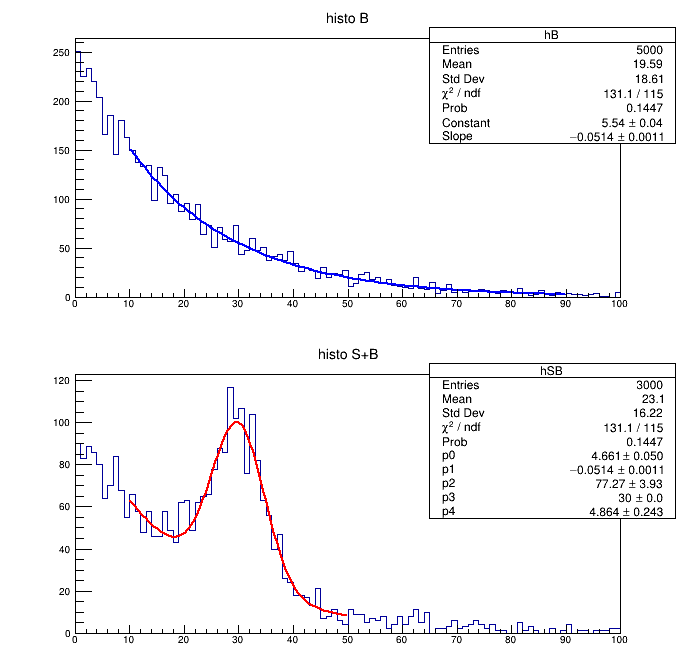

In [12]:
gROOT->GetListOfCanvases()->Draw()